In [1]:
import time
import sys
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pvtrace import *
from pvtrace.data import lumogen_f_red_305
from pvtrace.material.utils import lambertian
from pvtrace.geometry.utils import EPS_ZERO


class AirGapMirror(FresnelSurfaceDelegate):
    def __init__(self):
        super(AirGapMirror, self).__init__()

    def reflectivity(self, surface, ray, geometry, container, adjacent):
        return 1.0  # perfect reflector

    def reflected_direction(self, surface, ray, geometry, container, adjacent):
        normal = geometry.normal(ray.position)
        if not np.allclose((0.0, 0.0, 1.0), normal):  # top surface
            raise NotImplementedError("Not yet generalised to other surfaces.")
        # Currently this return lambertian direction along +z axis and is not
        # generalised to other orientations. This is simple to do using a transform
        # which first moves into to the z+ frame and then back out.
        return tuple(lambertian().tolist())


class SolarCell(FresnelSurfaceDelegate):
    """ A delegate adds perfectly indexed matched and perfectly absorbing solar cells to the edges.
    """

    def __init__(self):
        super(SolarCell, self).__init__()

    def reflectivity(self, surface, ray, geometry, container, adjacent):
        normal = geometry.normal(ray.position)
        if np.allclose((-1, 0, 0), normal):  # left
            return 0.0
        elif np.allclose((1, 0, 0), normal):  # right
            return 0.0
        elif np.allclose((0, -1, 0), normal):  # far
            return 0.0
        elif np.allclose((0, 1, 0), normal):  # near
            return 0.0

        # opt-out of custom surface reflection
        return super(SolarCell, self).reflectivity(
            surface, ray, geometry, container, adjacent
        )

    def transmitted_direction(self, surface, ray, geometry, container, adjacent):
        normal = geometry.normal(ray.position)
        if (
            np.allclose((-1, 0, 0), normal)
            or np.allclose((1, 0, 0), normal)
            or np.allclose((0, -1, 0), normal)
            or np.allclose((0, 1, 0), normal)
        ):
            return ray.direction  #  solar cell is perfectly index matched

        # opt-out of custom surface reflection
        return super(SolarCell, self).transmitted_direction(
            surface, ray, geometry, container, adjacent
        )


# Generate absorption and emission spectrum for Lumogen F Red 305
x = np.linspace(200, 800, 200)  # wavelength, units: nm
absorption_spectrum = lumogen_f_red_305.absorption(x)  # units: nm-1
emission_spectrum = lumogen_f_red_305.emission(x)  # units: nm-1
coefficient = np.column_stack((x, absorption_spectrum))
emission = np.column_stack((x, emission_spectrum))

# Create LSC containing the Lumogen F Red 305
size = (20.0, 20.0, 1.0)

world = Node(
    name="world (air)",
    geometry=Box((22.0, 22.0, 10), material=Material(refractive_index=1.0)),
)


lsc = Node(
    name="lsc",
    geometry=Box(
        size,
        material=Material(
            refractive_index=1.5,
            components=[
                Luminophore(
                    coefficient=coefficient,
                    emission=emission,
                    x=x,
                    hist=False,
                    quantum_yield=None,
                    tau_nr=100e-9,
                    tau_rad=20e-9,
                )
            ],
            surface=Surface(delegate=SolarCell()),
        ),
    ),
    parent=world,
)

mirror_thicknesses = 0.5 * size[2]
mirror_gap = 1e-3
air_gap_mirror = Node(
    name="Air Gap Mirror",
    geometry=Box(
        (size[0], size[1], mirror_thicknesses),  # same surface air but very thin
        material=Material(
            refractive_index=1.0,
            components=[],
            surface=Surface(delegate=AirGapMirror()),
        ),
    ),
    parent=world,
)
air_gap_mirror.translate(
    (0.0, 0.0, -(mirror_gap + 0.5 * mirror_thicknesses + 0.5 * size[2]))
)
# The z value of mirrors top surface facing the LSC
mirrorz = air_gap_mirror.location[2] + 0.5 * mirror_thicknesses


light = Node(
    name="Light (555nm)",
    light=Light(
        position=functools.partial(rectangular_mask, 0.5 * size[0], 0.5 * size[1])
    ),
    parent=world,
)
light.location = (0, 0, 2)
light.rotate(np.pi, (1, 0, 0))  # point downwards

#renderer = MeshcatRenderer(wireframe=True, max_histories=100, open_browser=True)
scene = Scene(world)
#renderer.render(scene)
all_histories = []
for ray in scene.emit(10000):
    history = photon_tracer.follow(scene, ray)
    all_histories.append(history)
    rays, events = zip(*history)
    #renderer.add_ray_path(rays)
    #time.sleep(0.01)


DEBUG:trimesh:searching for scad in: /Users/daniel/.pyenv/versions/3.7.2/envs/pvtrace-3.7.2/bin:/Users/daniel/.pyenv/shims:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/MacGPG2/bin:/opt/X11/bin:/Applications/OpenSCAD.app/Contents/MacOS
DEBUG:trimesh:searching for blender in: /Users/daniel/.pyenv/versions/3.7.2/envs/pvtrace-3.7.2/bin:/Users/daniel/.pyenv/shims:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/MacGPG2/bin:/opt/X11/bin:/Applications/blender.app/Contents/MacOS:/Applications/Blender.app/Contents/MacOS:/Applications/Blender/blender.app/Contents/MacOS
DEBUG:shapely.geos:Found GEOS DLL: <CDLL '/Users/daniel/.pyenv/versions/3.7.6/envs/pvtrace_dev/lib/python3.7/site-packages/shapely/.dylibs/libgeos_c.1.dylib', handle 7fac4e6a4c60 at 0x12b2786d8>, using it.
DEBUG:shapely.geos:Trying `CDLL(/usr/lib/libc.dylib)`
DEBUG:shapely.geos:Library path: '/usr/lib/libc.dylib'
DEBUG:shapely.geos:DLL: <CDLL '/usr/lib/libc.dylib', handle 1

Write some helper functions which process the raw path information into usable rates.

In [2]:

def summaries_history(history, identifier):
    rows = list()
    for ray, event in history:
        row = {
            "identifier": identifier,
            "source": ray.source,
            "x": ray.position[0],
            "y": ray.position[1],
            "z": ray.position[2],
            "i": ray.direction[0],
            "j": ray.direction[1],
            "k": ray.direction[2],
            "wavelength": ray.wavelength,
            "travelled": ray.travelled,
            "duration": ray.duration,
            "event": event.name,
        }
        rows.append(row)
    df = pd.DataFrame(rows)
    return df


def label_facets(df, length, width, height, mirrorz):
    """ Label rows with facet names for a box LSC.

        Notes
        -----
        This function only works if the coordinates in the dataframe
        are in the local frame of the box. If the coordinates are in the
        world frame then this will still work provided the box is axis
        aligned with the world node and centred at the origin.
    """
    xmin, xmax = -0.5*length, 0.5*length
    ymin, ymax = -0.5*width, 0.5*width
    zmin, zmax = -0.5*height, 0.5*height
    df.loc[(np.isclose(df['x'], xmin, atol=EPS_ZERO)), 'facet'] = 'left'
    df.loc[(np.isclose(df['x'], xmax, atol=EPS_ZERO)), 'facet'] = 'right'
    df.loc[(np.isclose(df['y'], ymin, atol=EPS_ZERO)), 'facet'] = 'far'
    df.loc[(np.isclose(df['y'], ymax, atol=EPS_ZERO)), 'facet'] = 'near'
    df.loc[(np.isclose(df['z'], zmin, atol=EPS_ZERO)), 'facet'] = 'bottom'
    df.loc[(np.isclose(df['z'], zmax, atol=EPS_ZERO)), 'facet'] = 'top'
    df.loc[(np.isclose(df['z'], mirrorz, atol=EPS_ZERO)), 'facet'] = 'mirror'
    return df

def categorise(df):
    if len(df.index) > 1:
        last = df.iloc[-1]
        penultimate = df.iloc[-2]
        edges = {'left', 'right', 'near', 'far'}
        apetures = {'top'}
        if last.event == 'EXIT':
            if last.source == 'Luminophore':
                if penultimate.facet in edges:
                    label = 'collected'
                    # Duration until collected
                    duration = penultimate.duration
                    
                    return {"label":label, "lifetime": duration}

                elif penultimate.facet == 'top':
                    label = 'escaped'
                    # Duration until escape
                    duration = penultimate.duration
    
                    return {"label":label, "lifetime": duration}
        
            elif last.source == 'Light':
                if penultimate.facet in apetures:
                    label = 'unabsorbed'
                    duration = penultimate.duration
                    return {"label":label, "lifetime": duration}
        elif last.event == 'NONRADIATIVE':
            duration = last.duration
            return {"label": "absorbed", "lifetime": duration}
 
    
    return {"label":"unknown", "lifetime": np.nan}

This is what the history of a single way looks like

In [3]:
df = summaries_history(all_histories[1], "0")
df = label_facets(df, *size, mirrorz)
df

,identifier,source,x,y,z,i,j,k,wavelength,travelled,duration,event,facet
0,0,Light,0.924212,4.596433,2.000000,0.000000,-1.224647e-16,-1.000000,555.000000,0.000000,0.000000e+00,GENERATE,NaN
1,0,Light,0.924212,4.596433,0.500000,0.000000,-8.164312e-17,-1.000000,555.000000,1.500000,5.003461e-11,TRANSMIT,top
2,0,Light,0.924212,4.596433,0.469847,0.000000,-8.164312e-17,-1.000000,555.000000,1.530153,5.154329e-11,ABSORB,NaN
3,0,Luminophore,0.924212,4.596433,0.469847,0.911513,3.996379e-01,-0.097129,579.271524,1.530153,1.535448e-08,EMIT,NaN
4,0,Luminophore,1.289099,4.756412,0.430966,0.911513,3.996379e-01,-0.097129,579.271524,1.930462,1.537451e-08,ABSORB,NaN
5,0,Luminophore,1.289099,4.756412,0.430966,0.911513,3.996379e-01,-0.097129,579.271524,1.930462,2.159517e-08,NONRADIATIVE,NaN


Apply the categorise function to each ray's history and return a data frame of lifetimes for different processes.

In [4]:
results = []
for idx, history in enumerate(all_histories):
    df = summaries_history(history, str(idx))
    df = label_facets(df, *size, mirrorz)
    result = categorise(df)
    results.append(result)

ratedf = pd.DataFrame(results)
ratedf = ratedf.dropna()
ratedf

,label,lifetime
0,escaped,3.511907e-08
1,absorbed,2.159517e-08
2,unabsorbed,1.571418e-10
3,unabsorbed,1.513177e-10
4,absorbed,5.347679e-08
...,...,...
9995,absorbed,7.727659e-09
9996,collected,5.949445e-08
9997,absorbed,2.726136e-08
9998,unabsorbed,1.641709e-10


Find the mean lifetime of each process and calculate efficiency parameters

In [6]:
from collections import Counter

tau_col = ratedf.where(ratedf.label=='escaped').lifetime.mean()
tau_col_ns = tau_col * 1e9
tau_esc = ratedf.where(ratedf.label=='collected').lifetime.mean()
tau_esc_ns = tau_esc * 1e9
tau_nr = ratedf.where(ratedf.label=='absorbed').lifetime.mean()
tau_nr_ns = tau_nr * 1e9

# Metrics
collection_efficiency = (1/tau_col) / (1/tau_col + 1/tau_esc + 1/tau_nr)
counts = Counter(ratedf.label.values)
collection_efficiency_from_counts = counts['collected'] / (counts['collected'] + counts['escaped'] + counts['absorbed'])

summary = pd.DataFrame({
    "tau_col": tau_col_ns,
    "tau_esc": tau_esc_ns,
    "tau_nr": tau_nr_ns,
    "eta_col": collection_efficiency,
    "eta_col (counts)": collection_efficiency_from_counts,
    },
    index=[0]
)
summary

,tau_col,tau_esc,tau_nr,eta_col,eta_col (counts)
0,33.980379,36.388819,113.35347,0.44771,0.444355


Time domain plots

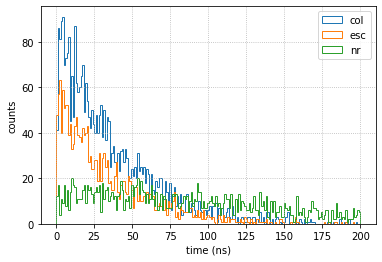

In [13]:
result = pd.DataFrame({
    "escaped":ratedf.where(ratedf.label=='escaped').lifetime.values,
    "collected": ratedf.where(ratedf.label=='collected').lifetime.values,
    "absorbed": ratedf.where(ratedf.label=='absorbed').lifetime.values,
})

bins = np.linspace(0,200,200)
plt.hist(result.collected.values * 1e9, histtype="step", bins=bins , label="col")
plt.hist(result.escaped.values * 1e9, histtype="step", bins=bins, label="esc")
plt.hist(result.absorbed.values * 1e9, histtype="step", bins=bins, label="nr")
plt.legend()
plt.grid(linestyle="dotted")
plt.xlabel("time (ns)")
plt.ylabel("counts")
plt.show()